# Diabetes Prediction using Random Forest

In this notebook, we will explore how to predict the presence of diabetes using the Random Forest algorithm. We'll utilize a dataset containing various health-related features of patients.

## Table of Contents

1. [Importing Libraries](#Importing-Libraries)
2. [Loading the Data](#Loading-the-Data)
3. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-EDA)
4. [Data Preprocessing](#Data-Preprocessing)
    - [Encoding Categorical Variables](#Encoding-Categorical-Variables)
    - [Feature Scaling](#Feature-Scaling)
5. [Splitting the Data](#Splitting-the-Data)
6. [Training the Random Forest Model](#Training-the-Random-Forest-Model)
7. [Making Predictions](#Making-Predictions)
8. [Model Evaluation](#Model-Evaluation)
    - [Confusion Matrix](#Confusion-Matrix)
    - [Classification Report](#Classification-Report)
    - [Feature Importance](#Feature-Importance)
9. [Conclusion](#Conclusion)
10. [Additional Recommendations](#Additional-Recommendations)

---

## Importing Libraries

First, we'll import the necessary libraries for data manipulation, visualization, and machine learning.


In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV


### Loading the Data
We'll load the dataset from a CSV file. It is importnant to ensure that the diabetes_prediction_dataset.csv file is in working directory (or we can provide the correct path to the file).

In [73]:
# Path to the CSV file
data_file = 'diabetes_prediction_dataset.csv'

# Loading the data
df = pd.read_csv(data_file)

# Display the first few rows
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [74]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

### Exploratory Data Analysis (EDA)
Before diving into model building, it's essential to understand the data's structure and check for any inconsistencies or missing values.

In [75]:
# Get information about the dataset
df.info()

# Get statistical summaries
df.describe()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   hba1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
hba1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

### Visualizing the Target Variable
Let's visualize the distribution of the target variable diabetes.

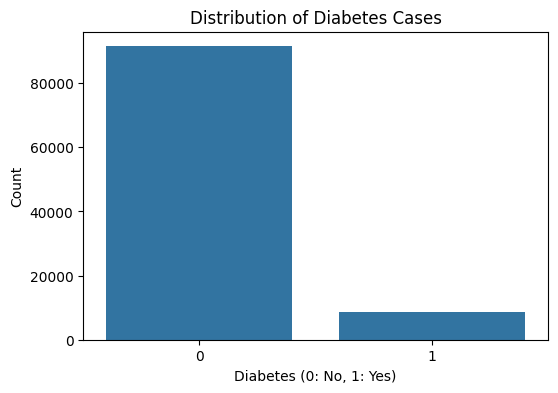

In [76]:
plt.figure(figsize=(6,4))
sns.countplot(x='diabetes', data=df)
plt.title('Distribution of Diabetes Cases')
plt.xlabel('Diabetes (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

**Feature Engineering:**
Explore creating new features or transforming existing ones to provide the model with more informative inputs.

In [119]:
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')

# Define bins for Age and BMI
age_bins = [0, 18, 30, 45, 60, 100]
age_labels = ['0-18', '19-30', '31-45', '46-60', '60+']
df['age_range'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

bmi_bins = [0, 18.5, 24.9, 29.9, 100]
bmi_labels = ['Underweight', 'Normal weight', 'Overweight', 'Obese']
df['bmi_group'] = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels)


In [120]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,hba1c_level,blood_glucose_level,diabetes,age_range,bmi_group
0,Female,80.0,0,1,never,25.19,6.6,140,0,60+,Overweight
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,46-60,Overweight
2,Male,28.0,0,0,never,27.32,5.7,158,0,19-30,Overweight
3,Female,36.0,0,0,current,23.45,5.0,155,0,31-45,Normal weight
4,Male,76.0,1,1,current,20.14,4.8,155,0,60+,Normal weight


Chi2 Statistic for gender: 141.2490041603208
p-value for gender: 1.4193639151521256e-32
Degrees of Freedom for gender: 1
Expected Frequencies for gender:
[[53574.18399312  4977.81600688]
 [37907.81600688  3522.18399312]]
There is a statistically significant association between gender and the occurrence of diabetes.



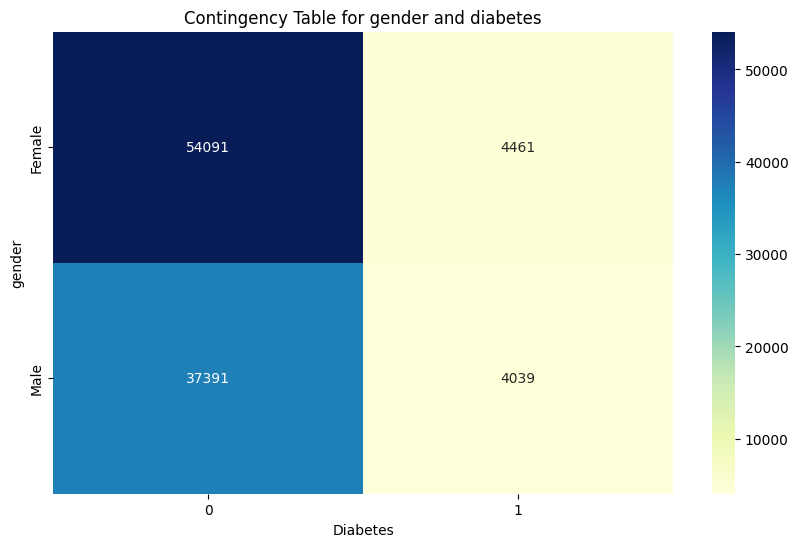

Chi2 Statistic for age_range: 7168.049134675668
p-value for age_range: 0.0
Degrees of Freedom for age_range: 4
Expected Frequencies for age_range:
[[16836.     1564.   ]
 [14029.695  1303.305]
 [18431.76   1712.24 ]
 [20579.265  1911.735]
 [21623.28   2008.72 ]]
There is a statistically significant association between age_range and the occurrence of diabetes.



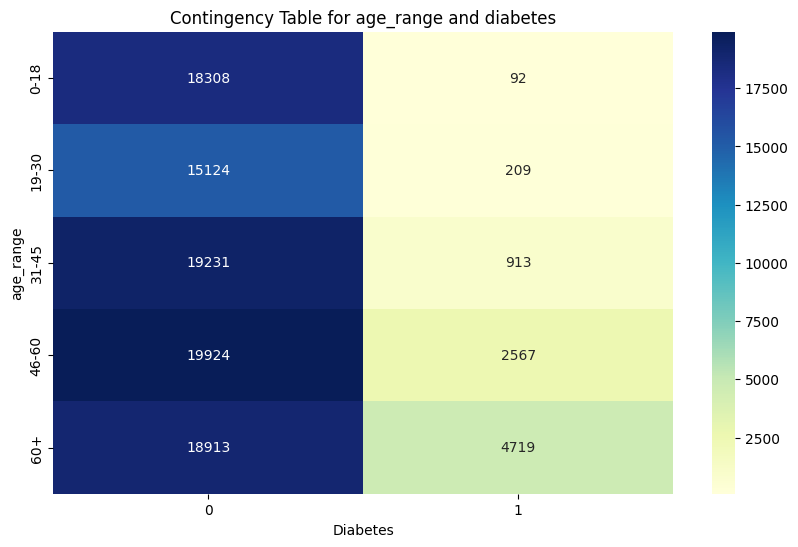

Chi2 Statistic for bmi_group: 4079.3359835340652
p-value for bmi_group: 0.0
Degrees of Freedom for bmi_group: 3
Expected Frequencies for bmi_group:
[[ 7796.715   724.285]
 [19975.365  1855.635]
 [41876.805  3890.195]
 [21851.115  2029.885]]
There is a statistically significant association between bmi_group and the occurrence of diabetes.



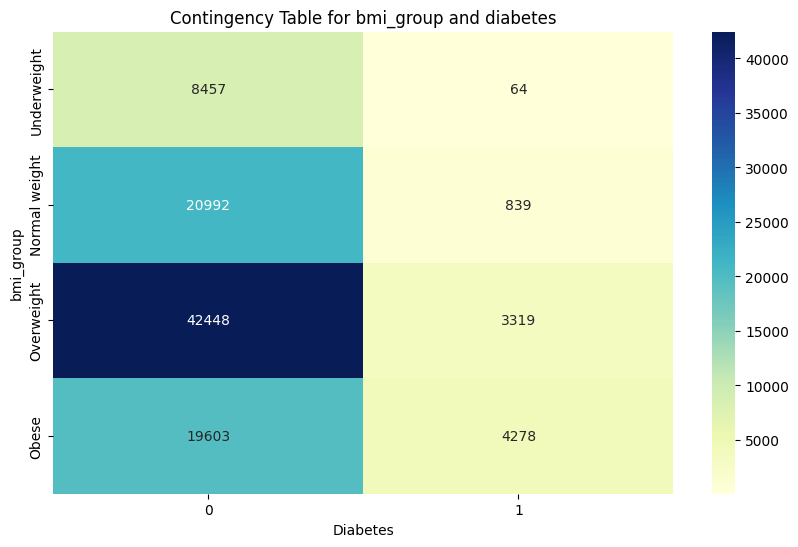

Chi2 Statistic for smoking_history: 1956.0944200848764
p-value for smoking_history: 0.0
Degrees of Freedom for smoking_history: 5
Expected Frequencies for smoking_history:
[[32771.64   3044.36 ]
 [ 8496.69    789.31 ]
 [ 3663.66    340.34 ]
 [ 8557.08    794.92 ]
 [32111.925  2983.075]
 [ 5899.005   547.995]]
There is a statistically significant association between smoking_history and the occurrence of diabetes.



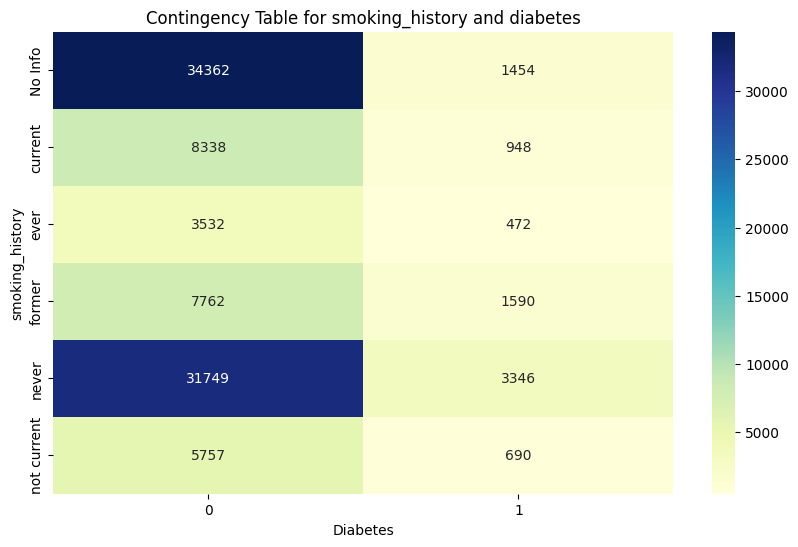

In [121]:
# Function to perform chi-square test for a given parameter and plot the contingency table
def chi_square_test(parameter):
   
    # Filter the DataFrame to include only 'Male' and 'Female' for the gender parameter
    if parameter == 'gender':
        df_filtered = df[df['gender'].isin(['Male', 'Female'])]
    else:
        df_filtered = df
    # Create a contingency table
    contingency_table = pd.crosstab(df_filtered[parameter], df_filtered['diabetes'])
    
    # Conducting the chi-square test
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    
    print(f'Chi2 Statistic for {parameter}: {chi2}')
    print(f'p-value for {parameter}: {p}')
    print(f'Degrees of Freedom for {parameter}: {dof}')
    print(f'Expected Frequencies for {parameter}:')
    print(ex)
    if p < 0.05:
        print(f"There is a statistically significant association between {parameter} and the occurrence of diabetes.\n")
    else:
        print(f"There is no statistically significant association between {parameter} and the occurrence of diabetes.\n")
    
    # Plotting the contingency table
    plt.figure(figsize=(10, 6))
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Contingency Table for {parameter} and diabetes')
    plt.xlabel('Diabetes')
    plt.ylabel(parameter)
    plt.show()

# List of parameters to test
parameters = ['gender', 'age_range', 'bmi_group', 'smoking_history']

# Perform chi-square test for each parameter
for parameter in parameters:
    chi_square_test(parameter)

By examining the associations between these specific parameters and the occurrence of diabetes, we aim to:

- Identify high-risk groups based on demographic and lifestyle factors.
- Develop targeted prevention and intervention strategies.
- Inform public health policies and resource allocation.
- Enhance our understanding of the multifactorial nature of diabetes and its risk factors.
- These parameters are chosen because they represent a combination of biological, behavioral, and demographic factors that are known to influence the risk of developing diabetes. Understanding these associations can lead to more effective prevention and management strategies for diabetes.

### Splitting the Data
We'll split the dataset into training and testing sets. We'll use 60% of the data for training and 20% for validation and testing.

In [122]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=len(df_test), random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.diabetes.values
y_train_full = df_train_full.diabetes.values
y_val = df_val.diabetes.values
y_test = df_test.diabetes.values


del df_train['diabetes']
del df_val['diabetes']
del df_test['diabetes']

### Data Preprocessing
**Encoding Categorical Variables**
The `gender` and `smoking_history` columns are categorical. We'll encode them into numerical values using `DictVectorizer`. This approach is particularly effective for handling categorical variables with multiple categories and ensures that the encoded features are suitable for machine learning algorithms.


In [132]:
train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

### Training the Random Forest Model
We'll use the RandomForestClassifier to train our model on the training data.

In [133]:
# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Making Predictions
After training the model, we'll use it to make predictions on the test set.

In [134]:
# Make predictions on the test set

X_val = dv.transform(df[df['diabetes'] == 1].iloc[1].drop('diabetes').to_dict())
y_pred = model.predict(X_val)
y_pred[0], df[df['diabetes'] == 1].iloc[0].to_dict()

(np.int64(1),
 {'gender': 'Female',
  'age': 44.0,
  'hypertension': 0,
  'heart_disease': 0,
  'smoking_history': 'never',
  'bmi': 19.31,
  'hba1c_level': 6.5,
  'blood_glucose_level': 200,
  'diabetes': 1,
  'age_range': '31-45',
  'bmi_group': 'Normal weight'})

In [135]:
def set_age_range_and_bmi_group(user_params):
    # Define bins and labels for age and BMI
    age_bins = [0, 18, 30, 45, 60, 100]
    age_labels = ['0-18', '19-30', '31-45', '46-60', '60+']
    bmi_bins = [0, 18.5, 24.9, 29.9, 100]
    bmi_labels = ['Underweight', 'Normal weight', 'Overweight', 'Obese']
    
    # Determine the age range
    user_age = user_params['age']
    user_params['age_range'] = pd.cut([user_age], bins=age_bins, labels=age_labels)[0]
    
    # Determine the BMI group
    user_bmi = user_params['bmi']
    user_params['bmi_group'] = pd.cut([user_bmi], bins=bmi_bins, labels=bmi_labels)[0]
    
    return user_params

# Example user parameters
user_params = {
    'gender': 'Female',
    'age': 44.0,
    'hypertension': 0,
    'heart_disease': 0,
    'smoking_history': 'never',
    'bmi': 19.31,
    'hba1c_level': 6.5,
    'blood_glucose_level': 200
}

# Set the proper age_range and bmi_group
updated_user_params = set_age_range_and_bmi_group(user_params)

### Model Evaluation
**Accuracy Score**

We'll evaluate the model's accuracy on the test set

In [136]:
test_dict = df_test.to_dict(orient='records')

X_test = dv.transform(test_dict)
y_pred = model.predict(X_test)


In [137]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.97


**Confusion Matrix**

A confusion matrix provides a summary of prediction results on the classification problem.

Accuracy of the loaded model: 0.97

Classification Report for Loaded Model:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18299
           1       0.96      0.69      0.80      1701

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



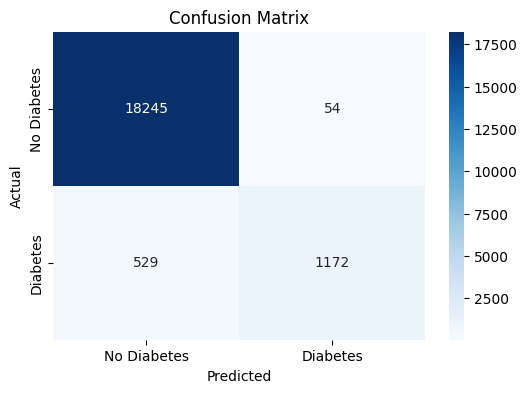

In [138]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the loaded model: {accuracy:.2f}')
print('\nClassification Report for Loaded Model:')
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

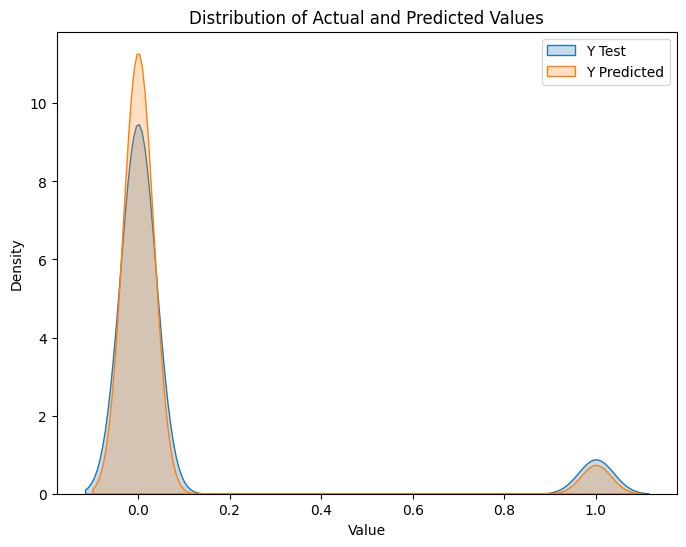

In [139]:
# Creating a DataFrame with actual and predicted values
results = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Plotting the distributions
plt.figure(figsize=(8,6))
sns.kdeplot(results['y_test'], label='Y Test', fill=True)
sns.kdeplot(results['y_pred'], label='Y Predicted', fill=True)
plt.title('Distribution of Actual and Predicted Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

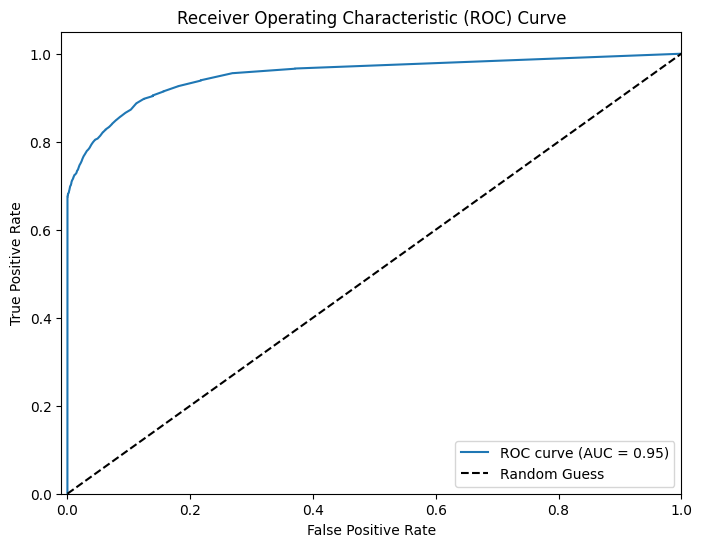

In [140]:
# Calculating probabilities for the positive class
y_probs = model.predict_proba(X_test)[:, 1]

# Calculating FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculating AUC
auc = roc_auc_score(y_test, y_probs)

# Plotting the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Classification Report**

The classification report provides detailed metrics about the model's performance.

In [141]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     18299
           1       0.96      0.69      0.80      1701

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000



**Feature Importance**

Understanding which features contribute most to the prediction can provide valuable insights.

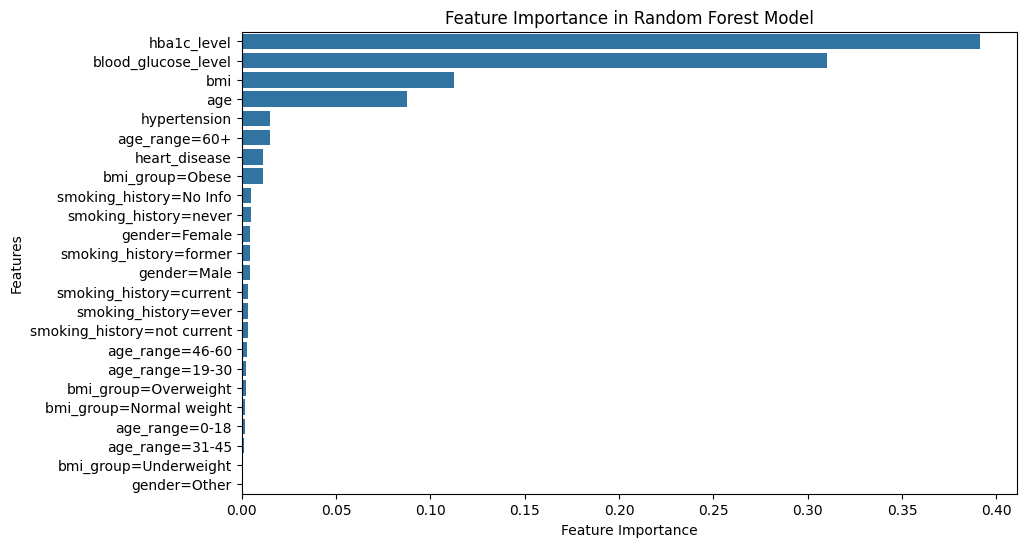

Most important feature: hba1c_level


In [142]:


# Get feature names and importances
feature_names = dv.get_feature_names_out()
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Model')
plt.show()

# Find the most important feature
most_important_index = np.argmax(importances)
most_important_feature = feature_names[most_important_index]

# Display the most important feature
print(f'Most important feature: {most_important_feature}')


### Conclusion
The Random Forest model achieved an accuracy of approximately 95%, indicating a high level of performance in predicting diabetes based on the provided features. The confusion matrix and classification report further confirm the model's reliability, showing minimal false positives and false negatives. Feature importance analysis reveals which factors are most influential in the predictions, providing valuable insights for healthcare professionals.



**Additional**

Hyperparameter Tuning: Utilize techniques like GridSearchCV to find the optimal hyperparameters for the Random Forest model, potentially enhancing its performance.

In [143]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}


# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)


In [144]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)
# Best parameters and best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Accuracy: {grid_search.best_score_:.2f}')

# Save the best model
model_filename = 'best_random_forest_model.joblib'
joblib.dump(grid_search.best_estimator_, model_filename)
dv_filename = 'dict_vectorizer.joblib'
joblib.dump(dv, dv_filename)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   6.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   6.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   7.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   7.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   7.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  13.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  14.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  14.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  13.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  14.9s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   7.5s
[CV] END max_depth=None, 

['dict_vectorizer.joblib']

**Handling Imbalanced Data:**
 If the dataset has an imbalanced distribution of classes, we can using techniques like SMOTE (Synthetic Minority Over-sampling Technique) or undersampling to balance the classes

In [145]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f'Original training data shape: {X_train.shape}')
print(f'Resampled training data shape: {X_train_resampled.shape}')

Original training data shape: (60000, 24)
Resampled training data shape: (109750, 24)


Accuracy after SMOTE: 0.97
Classification Report after SMOTE:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18299
           1       0.89      0.71      0.79      1701

    accuracy                           0.97     20000
   macro avg       0.93      0.85      0.89     20000
weighted avg       0.97      0.97      0.97     20000



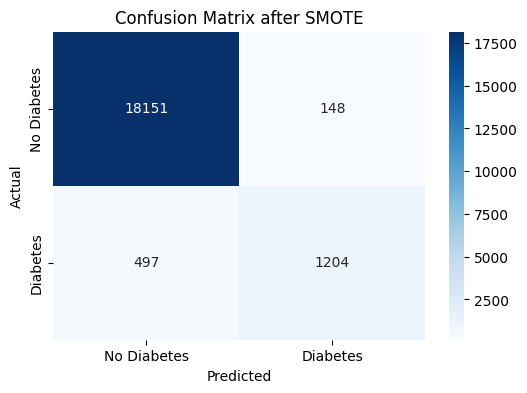

In [146]:
# Train the model on resampled data
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_resampled = model.predict(X_test)

# Evaluate the model
print(f'Accuracy after SMOTE: {accuracy_score(y_test, y_pred_resampled):.2f}')
print('Classification Report after SMOTE:\n', classification_report(y_test, y_pred_resampled))

# Plot the confusion matrix
conf_matrix_resampled = confusion_matrix(y_test, y_pred_resampled)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_resampled, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix after SMOTE')
plt.show()
